# Synthetic receive sensitivies

Modern MRI scanners use multi-channel phased-array coils to acquire the
data. These coils are made of a large number of small elements whose
receptive field is highly localized, giving rise to a number of coil
images that contain a very inhomogeneous intensity profile. These
individual images are then combined, typically by taking the
sum-of-squares, into a single magnitude image.

Sensitivities are complex and often contain phase singularities that
lead to a sudden and localized signal loss. The exact location of these
singularities depend on the loading of tre coil, and therfore on the
shape and position of the head (or other organ of interest) inside the coil.
They therefore cannot be measure once per scanner, and better augmentation
is obtained by sampling random sensitivity profiles at each minibatch.

In [1]:
import torch
from cornucopia import ArrayCoilTransform
from cornucopia.utils.py import meshgrid_ij
import  matplotlib.pyplot as plt
import math

Let's generate a synthetic signal magnitude. We use circles of varying radii.

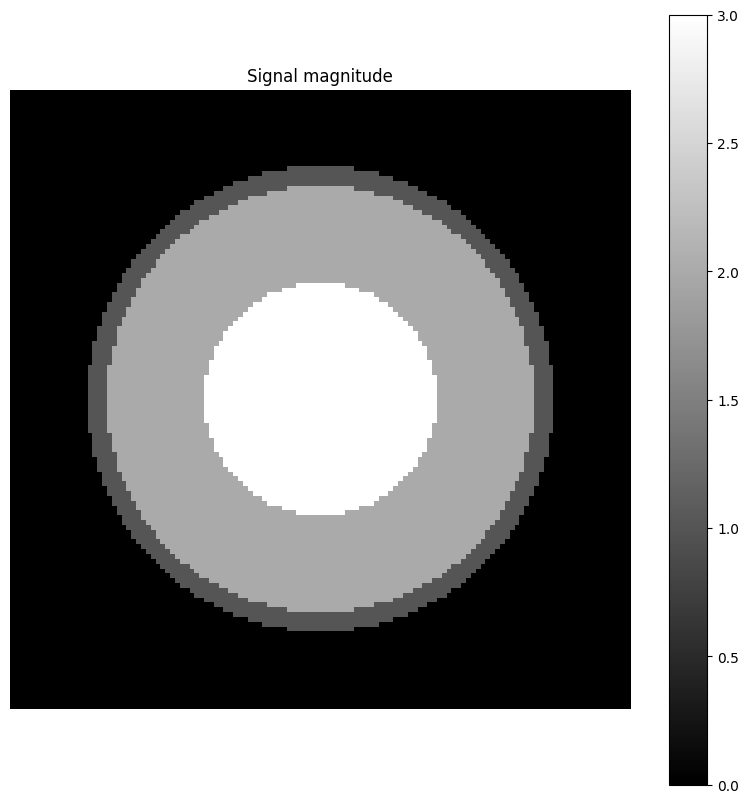

In [2]:
shape = [128, 128]
radius = torch.stack(meshgrid_ij(*[torch.arange(s).float() for s in shape]), -1)
radius -= (torch.as_tensor(shape).float() - 1) / 2
radius = radius.square().sum(-1).sqrt()

mag = torch.zeros_like(radius, dtype=torch.float32)
mag[radius < 48] = 1
mag[radius < 44] = 2
mag[radius < 24] = 3

plt.figure(figsize=(10, 10))
plt.imshow(mag, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Signal magnitude')
plt.colorbar()
plt.show()

First scenario: generate individual complex coil images
(Note that with the current API, this will only work for
single channel inputs)

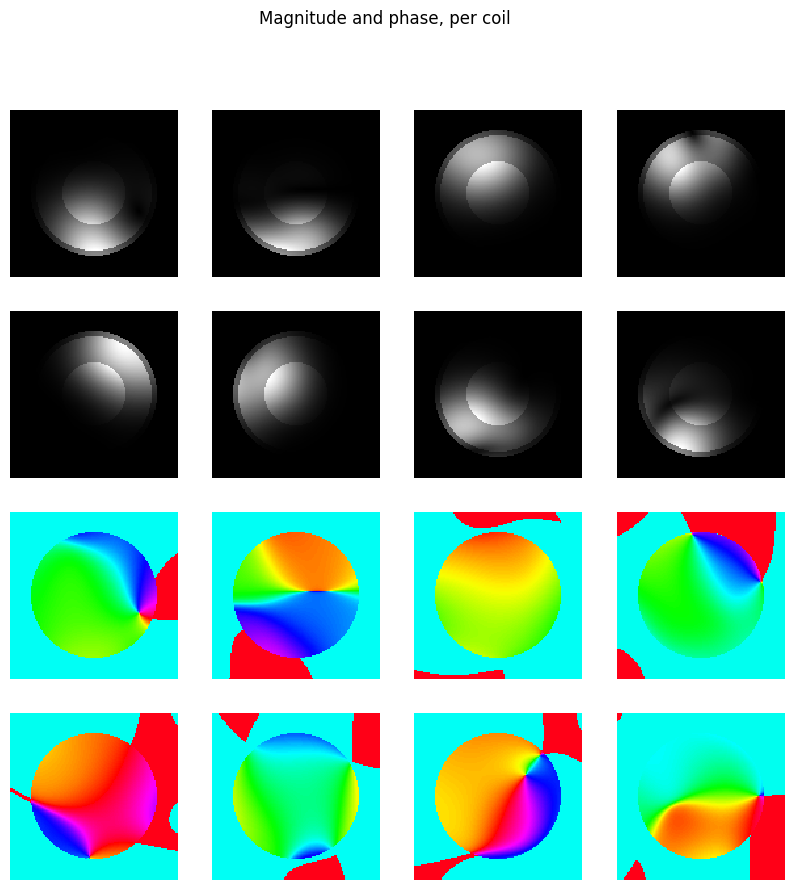

In [3]:
trf = ArrayCoilTransform(ncoils=8)
coils = trf(mag[None])

plt.figure(figsize=(10, 10))
for k in range(len(coils)):
    plt.subplot(4, 4, k+1)
    plt.imshow(coils[k].abs(), cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.subplot(4, 4, 8+k+1)
    plt.imshow(coils[k].angle(), cmap='hsv', interpolation='nearest',
               vmin=-math.pi, vmax=math.pi)
    plt.axis('off')
plt.suptitle('Magnitude and phase, per coil')
plt.show()

Second scenario: directly generate the sum-of-square image.

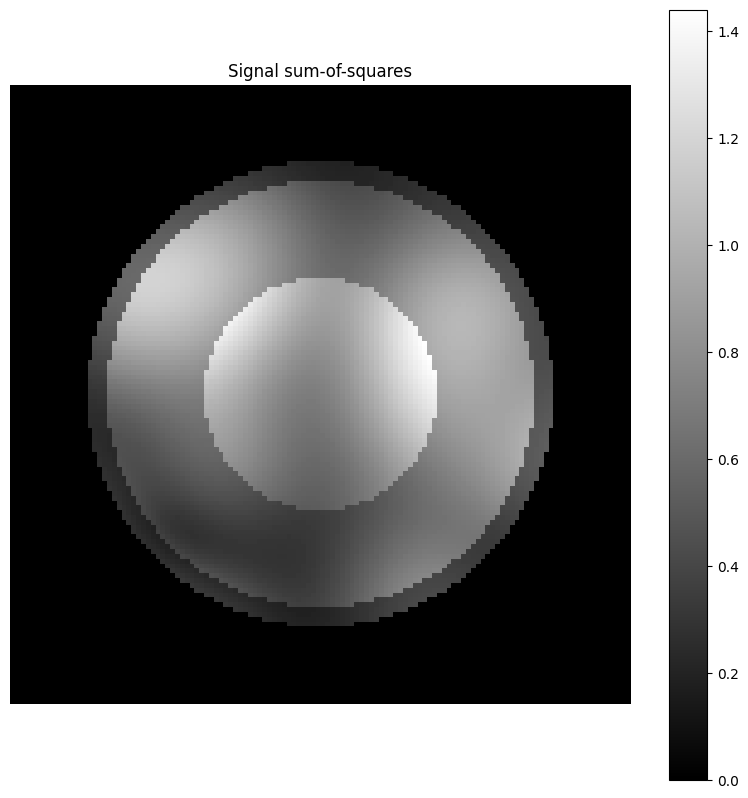

In [4]:
trf = ArrayCoilTransform(returns='sos')
sos = trf(mag[None])[0]

plt.figure(figsize=(10, 10))
plt.imshow(sos, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Signal sum-of-squares')
plt.colorbar()
plt.show()